In [1]:
import pandas as pd
import numpy as np

In [2]:
county_cases = pd.read_csv("./data/jhu/county_cases_04-30-2020.csv")

In [3]:
county_cases.columns = ['FIPS', 'county', 'state', 'country_region', 'last_update', 'lat', 'long', 'confirmed', 'deaths', 'recovered', 'active', 'combined_key']
county_cases = county_cases[county_cases['country_region'] == 'US']

In [4]:
county_cases.head()

,FIPS,county,state,country_region,last_update,lat,long,confirmed,deaths,recovered,active,combined_key
0,45001.0,Abbeville,South Carolina,US,2020-05-01 02:32:28,34.223334,-82.461707,31,0,0,31,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-01 02:32:28,30.295065,-92.414197,130,10,0,120,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-01 02:32:28,37.767072,-75.632346,264,4,0,260,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-01 02:32:28,43.452658,-116.241552,671,16,0,655,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-01 02:32:28,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US"


In [5]:
population = pd.read_csv('./data/census/co-est2019-alldata-1.csv')
population = population.iloc[:, [0, 1, 2, 3, 4, 5, 6, 17]]
population = population[population['COUNTY'] != 0]
population['FIPS'] = (population['STATE'].astype(str) + population['COUNTY'].astype(str).str.pad(3, fillchar='0')).astype(float)
population = population.iloc[:, -2:]

In [6]:
population.head()

,POPESTIMATE2018,FIPS
1,55533,1001.0
2,217855,1003.0
3,24872,1005.0
4,22367,1007.0
5,57771,1009.0


In [7]:
# NOTE: 74 regions are being dropped because we have information on COVID but not population. Decide later if we'd like to keep
merged = pd.merge(county_cases, population, how='inner', on='FIPS')

In [8]:
'''NOTE: Johns Hopkins consolidates all of New York City into one row. This means that the population data for New York City does not enter the data properly
To account for this, we have manually pulled in the US Census Population Estimate for New York City as of July 1, 2018 from https://www.census.gov/quickfacts/newyorkcitynewyork
'''

merged.loc[merged['FIPS'] == 36061, 'POPESTIMATE2018'] = 8398748
merged['confirmed_per_100k'] = merged['confirmed'] * 100000 / merged['POPESTIMATE2018']
merged['deaths_per_100k'] = merged['deaths'] * 100000 / merged['POPESTIMATE2018']

In [9]:
merged.sort_values('confirmed_per_100k', ascending=False).head()

,FIPS,county,state,country_region,last_update,lat,long,confirmed,deaths,recovered,active,combined_key,POPESTIMATE2018,confirmed_per_100k,deaths_per_100k
1485,5079.0,Lincoln,Arkansas,US,2020-05-01 02:32:28,33.953172,-91.740028,814,0,0,814,"Lincoln, Arkansas, US",13184,6174.150485,0.000000
196,47007.0,Bledsoe,Tennessee,US,2020-05-01 02:32:28,35.599430,-85.206120,594,0,0,594,"Bledsoe, Tennessee, US",14883,3991.130820,0.000000
2216,36087.0,Rockland,New York,US,2020-05-01 02:32:28,41.150279,-74.025605,11708,511,0,11197,"Rockland, New York, US",325522,3596.684709,156.978637
1882,27105.0,Nobles,Minnesota,US,2020-05-01 02:32:28,43.674346,-95.753296,742,1,0,741,"Nobles, Minnesota, US",21744,3412.435614,4.598970
1615,39101.0,Marion,Ohio,US,2020-05-01 02:32:28,40.586107,-83.157363,2196,4,0,2192,"Marion, Ohio, US",65427,3356.412490,6.113684


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

sns.set(rc={'figure.figsize':(16, 4)})

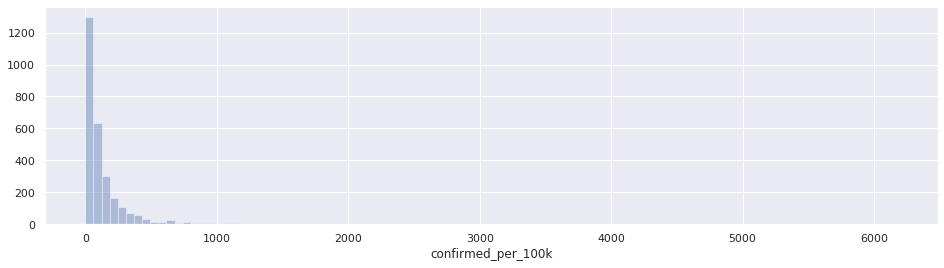

In [11]:
sns.distplot(merged['confirmed_per_100k'], kde=False, bins=100)

In [12]:
merged['confirmed_per_100k'].describe()

count    2838.000000
mean      162.374006
std       327.731912
min         0.000000
25%        33.574792
50%        68.021744
75%       159.727737
max      6174.150485
Name: confirmed_per_100k, dtype: float64

Text(0.5, 0, 'Confirmed Cases per 100,000 people')

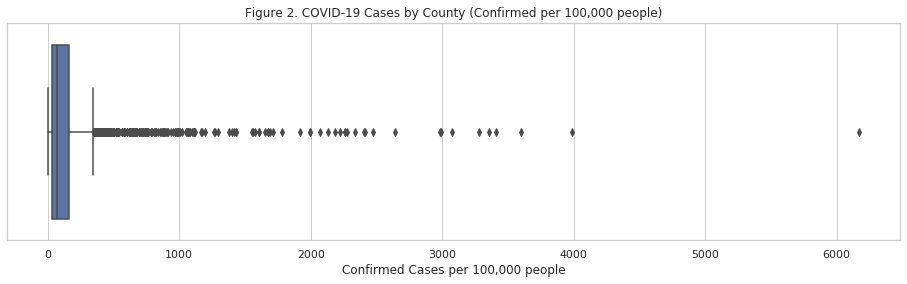

In [14]:
plt.title('Figure 2. COVID-19 Cases by County (Confirmed per 100,000 people)')
sns.boxplot(x=merged['confirmed_per_100k'])
sns.set(style='whitegrid')
plt.xlabel('Confirmed Cases per 100,000 people')